## Import all the required packages

In [217]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Load the dataset and analyze the data set

In [2]:
bike_data = pd.read_csv('day.csv')
print(bike_data.shape)
print(bike_data.info())
print(bike_data.nunique())

(730, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB
None
instant       730
dteday        730
season          4
yr              2
mnth  

In [14]:
bike_data.head(100)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,06-04-2018,2,0,4,0,3,1,1,16.024153,19.38040,47.0833,17.625221,413,2395,2808
96,97,07-04-2018,2,0,4,0,4,1,1,17.937500,21.68480,60.2917,10.874904,571,2570,3141
97,98,08-04-2018,2,0,4,0,5,1,2,13.769153,16.22395,83.6250,15.208464,172,1299,1471
98,99,09-04-2018,2,0,4,0,6,0,2,14.042500,17.07645,87.7500,8.916561,879,1576,2455


## Cleaning and preprocessing data.

In [99]:
# Drop columns which are irrelevant.
columns_to_be_dropped = []

# 'instant' column is just a unique row indentifier. So can be dropped.
#  'dteday' is a unique for each row. so can be dropped.
columns_to_be_dropped.extend(['instant', 'dteday'])

# Here target variable is 'cnt'. So, we can drop columns which have a direct mathematical relationiship with it. As inclusion of those can
# not generalize new unseen variables. Here cnt = casual + registered so both columns can be dropped.
columns_to_be_dropped.extend(['casual', 'registered'])

# Check correlation between temp and atemp to understand the correlation. Given the high correlation (above 0.9),
# we can safely drop one of these columns to avoid multicollinearity and reduce redundancy in our model.
print(bike_data[['temp', 'atemp']].corr())
columns_to_be_dropped.extend(['atemp'])

bike_data_cleaned = bike_data.drop(columns_to_be_dropped, axis=1)

# Map all values of categorical variables from the data dictionary. First let's map season column with categorical value.
season_mapping = {
    1: 'Spring',
    2: 'Summer',
    3: 'Fall',
    4: 'Winter'
}
bike_data_cleaned['season'] = bike_data['season'].map(season_mapping)
bike_data_cleaned['season'].value_counts()

# Now, let's create dummy variables to represent the season columns. Can drop the first column to avoid multi colinearity 
season_dummies = pd.get_dummies(bike_data_cleaned['season'], prefix='season', drop_first=True)
# print(season_dummies)
bike_data_cleaned = pd.concat([bike_data_cleaned, season_dummies], axis=1)

#Now we can drop the original season column as from season column we have created two derived columns that we ll be using.
bike_data_cleaned.drop('season', axis=1, inplace=True)

# Now let's convert another categorical variable i.e weathersit. Only 3 types of weathersit available. 1, 2 ,3
# print(bike_data_cleaned['weathersit'].value_counts())
weathersit_mapping = {
    1: 'Clear',
    2: 'Cloudy',
    3: 'Rain'
}
bike_data_cleaned['weathersit'] = bike_data['weathersit'].map(weathersit_mapping)
weathersit_dummies = pd.get_dummies(bike_data_cleaned['weathersit'], prefix='weather', drop_first=True)

bike_data_cleaned = pd.concat([bike_data_cleaned, weathersit_dummies], axis=1)
bike_data_cleaned.drop('weathersit', axis=1, inplace=True)

print(bike_data_cleaned.head())

   yr  mnth  holiday  weekday  workingday       temp      hum  windspeed  \
0   0     1        0        6           0  14.110847  80.5833  10.749882   
1   0     1        0        0           0  14.902598  69.6087  16.652113   
2   0     1        0        1           1   8.050924  43.7273  16.636703   
3   0     1        0        2           1   8.200000  59.0435  10.739832   
4   0     1        0        3           1   9.305237  43.6957  12.522300   

    cnt  season_Spring  season_Summer  season_Winter  weather_Cloudy  \
0   985           True          False          False            True   
1   801           True          False          False            True   
2  1349           True          False          False           False   
3  1562           True          False          False           False   
4  1600           True          False          False           False   

   weather_Rain  
0         False  
1         False  
2         False  
3         False  
4         False  


## Univariate and bivariate analysis

Number of numerical columns is 9 Index(['yr', 'mnth', 'holiday', 'weekday', 'workingday', 'temp', 'hum',
       'windspeed', 'cnt'],
      dtype='object')
               yr        mnth     holiday     weekday  workingday        temp  \
count  714.000000  714.000000  714.000000  714.000000  714.000000  714.000000   
mean     0.497199    6.563025    0.029412    2.985994    0.686275   20.409431   
std      0.500343    3.433942    0.169076    1.998548    0.464332    7.521732   
min      0.000000    1.000000    0.000000    0.000000    0.000000    2.424346   
25%      0.000000    4.000000    0.000000    1.000000    0.000000   13.940000   
50%      0.000000    7.000000    0.000000    3.000000    1.000000   20.739153   
75%      1.000000   10.000000    0.000000    5.000000    1.000000   26.923347   
max      1.000000   12.000000    1.000000    6.000000    1.000000   35.328347   

              hum   windspeed          cnt  
count  714.000000  714.000000   714.000000  
mean    63.062084   12.43

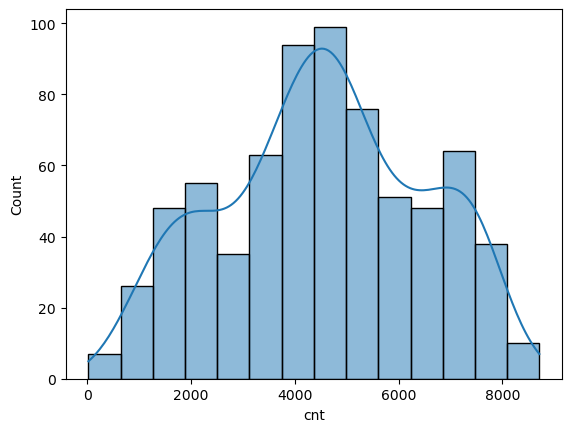

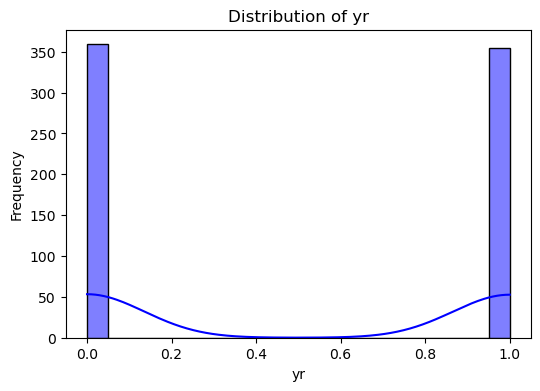

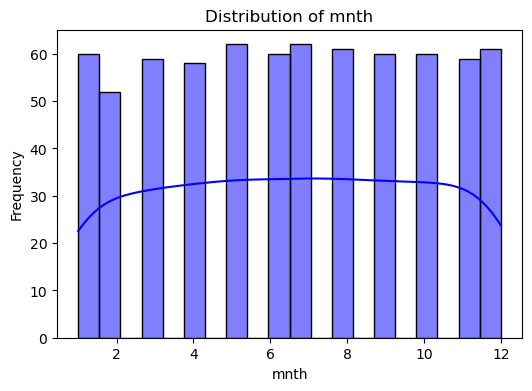

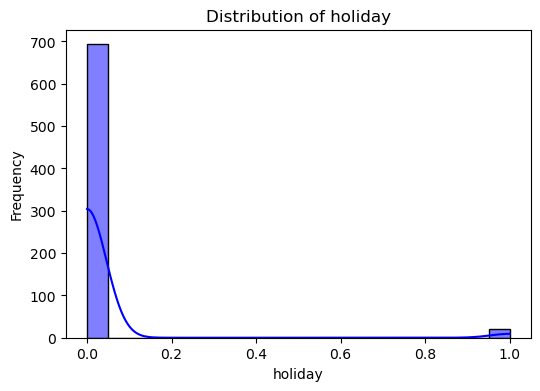

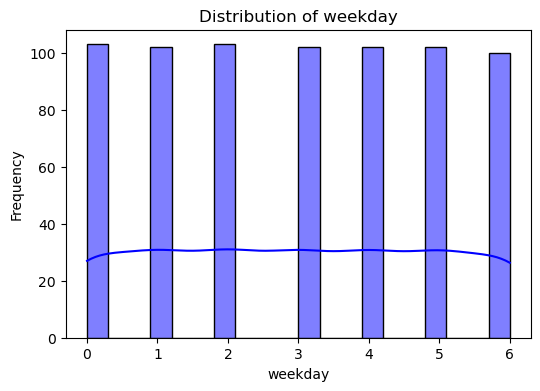

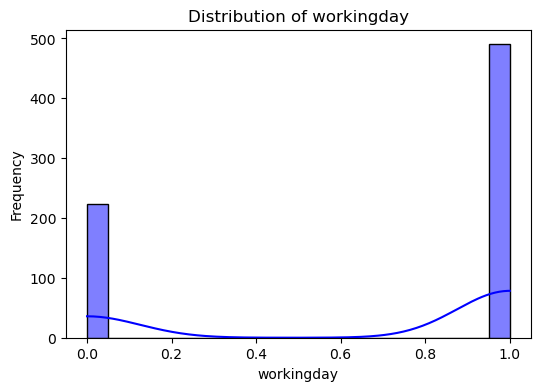

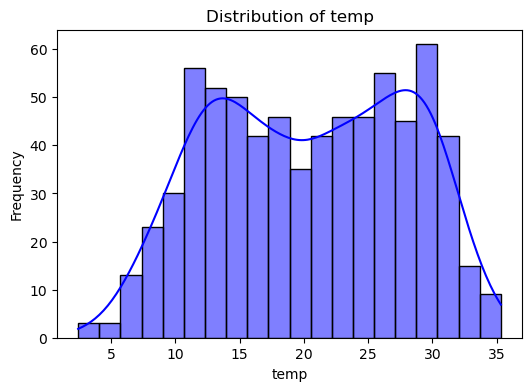

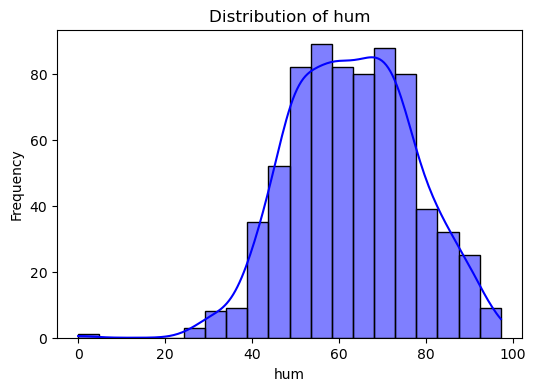

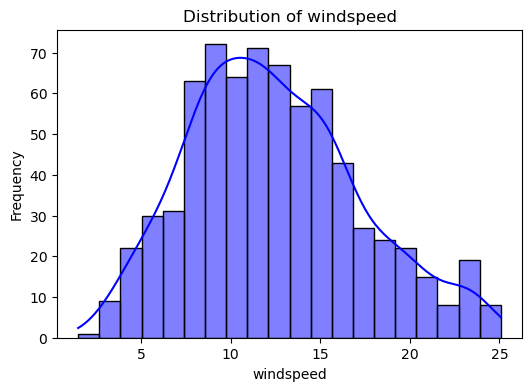

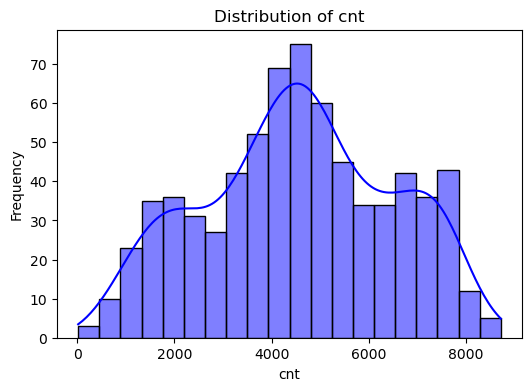

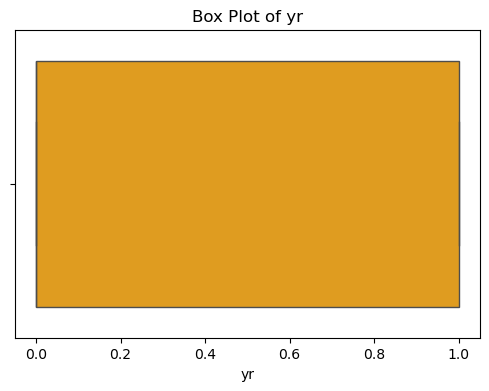

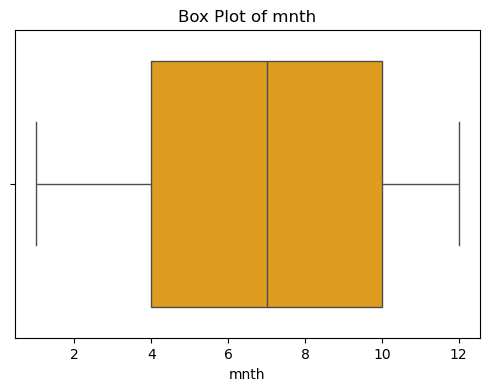

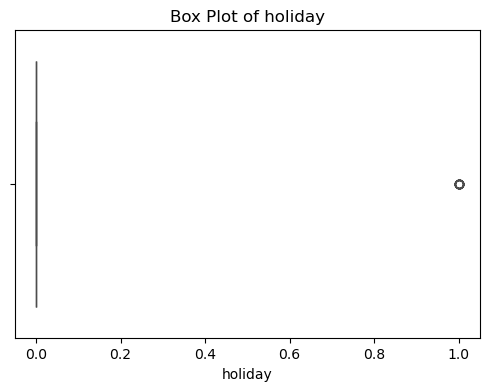

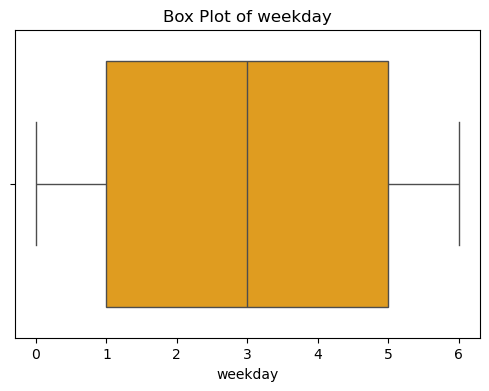

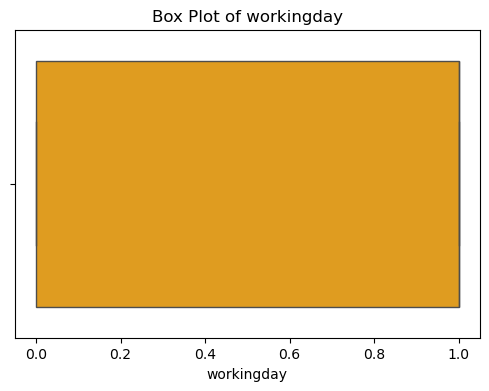

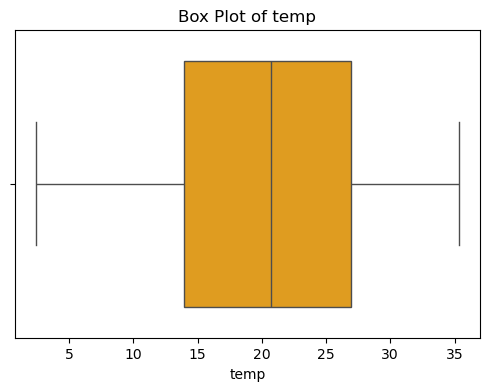

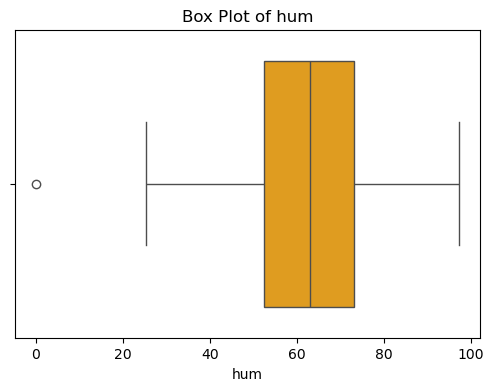

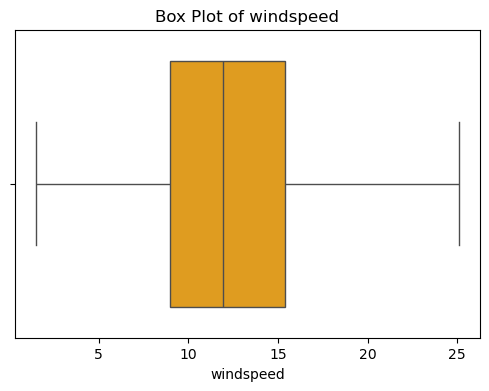

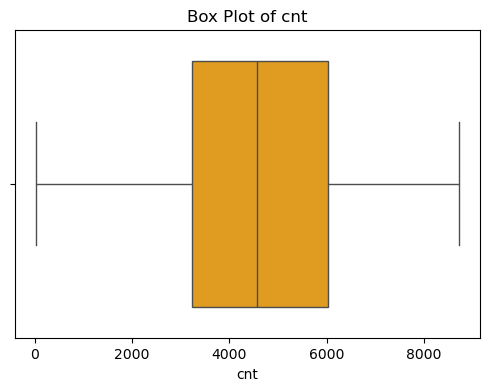

cnt           1.000000
temp          0.628376
yr            0.581074
mnth          0.279231
weekday       0.077978
workingday    0.050605
holiday      -0.072601
hum          -0.120135
windspeed    -0.209307
Name: cnt, dtype: float64
Number of categorical columns is 0
Number of boolean columns is 5


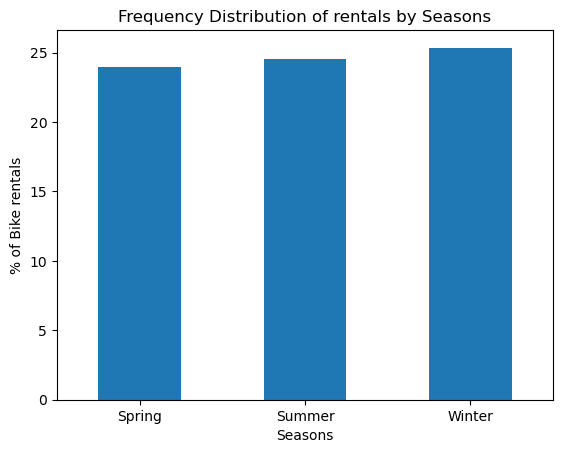

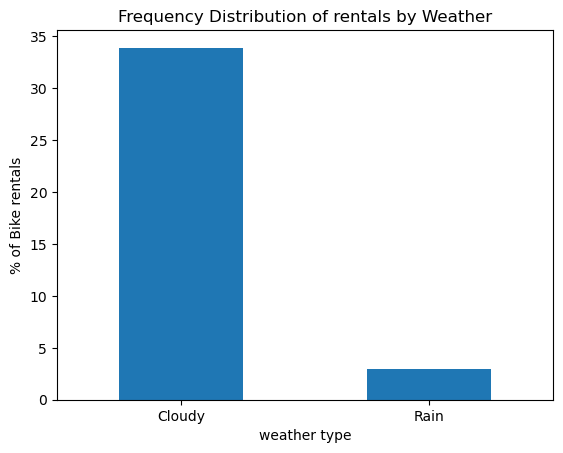

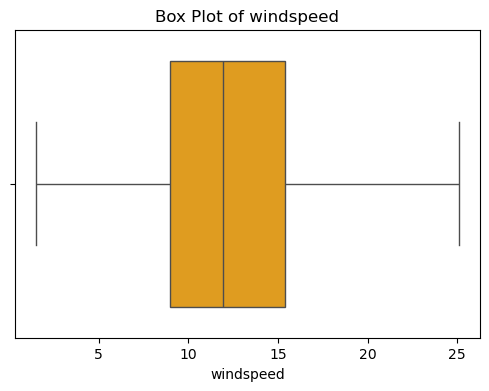

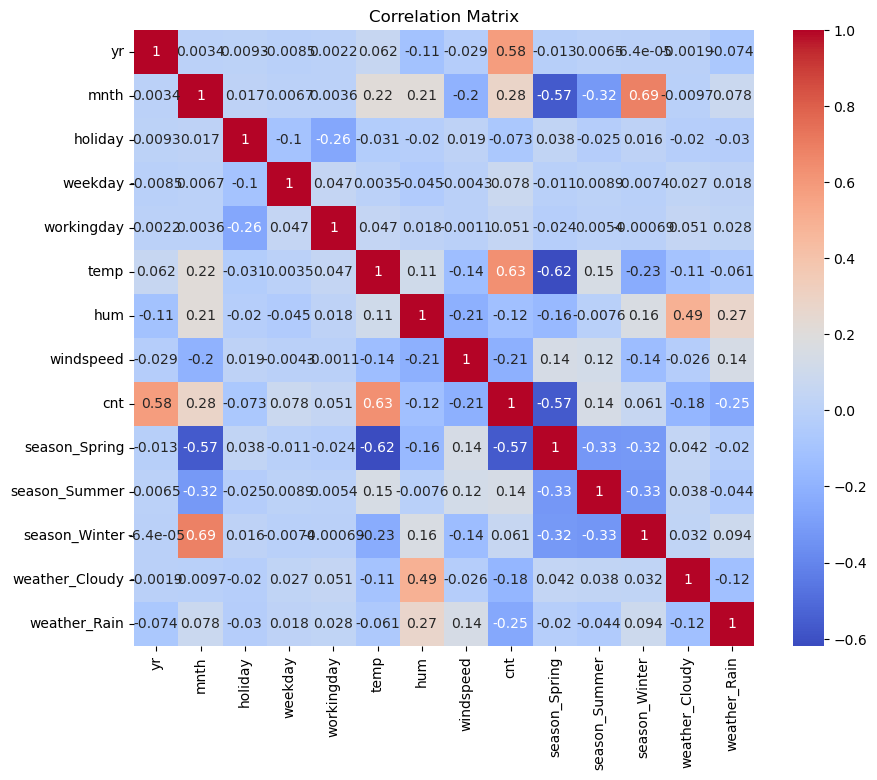

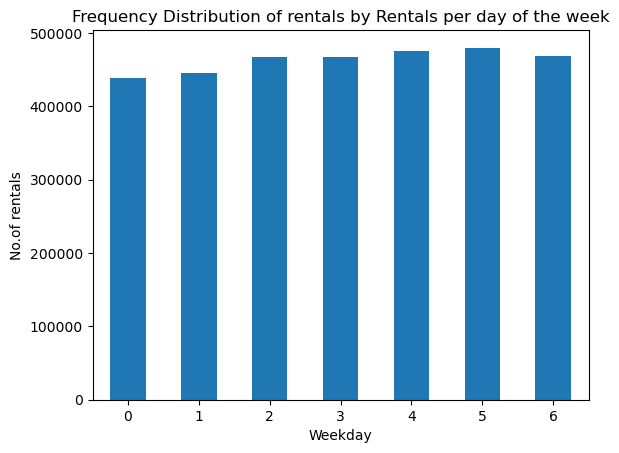

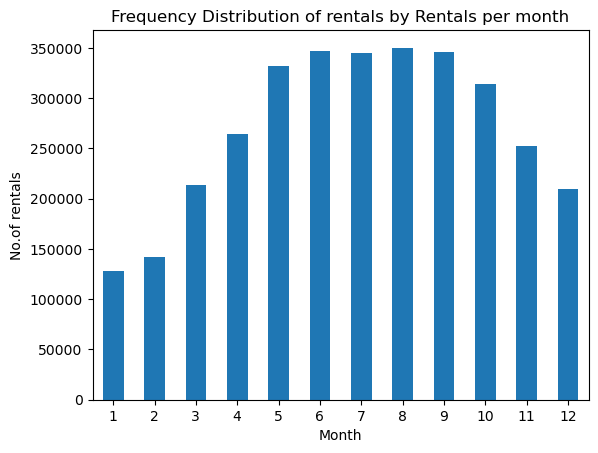

In [268]:
# # Plot the histplot of the target variable to check for skewness. Seems like almost normally distributed.
sns.histplot(bike_data_cleaned['cnt'], kde=True)

# Let's confirm the skewness. Skewness between -0.5 to 0.5 so symmetric.
bike_data_cleaned['cnt'].skew()

# From the below stats, Seems like bike rentals are equally distributed across each month.
# print(bike_data_cleaned['mnth'].value_counts())


# bike_data_cleaned['weekday'].value_counts()

# Let's do the univarite analysis of all the numerical columns to see the distribution using histogram and outliers using box plot
numerical_columns = bike_data_cleaned.select_dtypes(include=['int64', 'float64']).columns
print(f'Number of numerical columns is {len(numerical_columns)} {numerical_columns}')

# Summary statistics
print(bike_data_cleaned[numerical_columns].describe())

# Histograms
for col in numerical_columns:
    drawHistPlot(bike_data_cleaned, col)

# Box plots
for col in numerical_columns:
    drawBoxPlot(bike_data_cleaned, col)

# Display correlation with the target variable
correlation_matrix = bike_data_cleaned[numerical_columns].corr()
print(correlation_matrix['cnt'].sort_values(ascending=False))

# Let's analyze the categorical coloumns. Visualize using bar plot.
categorical_columns = bike_data_cleaned.select_dtypes(include=['object', 'category']).columns
print(f'Number of categorical columns is {len(categorical_columns)}')

#There is no categorical columns anymore. Let's analyze booelean columns.
boolean_columns = bike_data_cleaned.select_dtypes(include=['bool']).columns
print(f'Number of boolean columns is {len(boolean_columns)}')

season_wise_counts = bike_data_cleaned[['season_Spring', 'season_Winter', 'season_Summer']].sum()
season_wise_percentage = (season_wise_counts / len(bike_data_cleaned)) * 100

# Draw a bar plot to show which season rental is highest percentage.
drawBarPlot(season_wise_percentage, 'Seasons', 'Seasons', '% of Bike rentals', [0, 1, 2], ['Spring', 'Summer', 'Winter'] )
# No significant difference across each season.

weathersit_counts = bike_data_cleaned[['weather_Cloudy', 'weather_Rain']].sum()
weathersit_wise_percentage = (weathersit_counts / len(bike_data_cleaned)) * 100

# Draw a bar plot to show which weathersit is highest percentage.
drawBarPlot(weathersit_wise_percentage, 'Weather', 'weather type', '% of Bike rentals', [0, 1], ['Cloudy', 'Rain'] )
#Conclusion: Clearly indicates that overcast conditions more % of bike rentals.


# From the box plot analysis of the numerical columns we can see some outliers in the windspeed columns. So, let's remove those outliers using IQR.
bike_data_cleaned = remove_outliers(bike_data_cleaned, 'windspeed')
drawBoxPlot(bike_data_cleaned, 'windspeed')


# Correlation matrix
correlation_matrix = bike_data_cleaned.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# temp and cnt shows a moderate to strong co-relation. Linear relationship.

# Bar plot: Average bike rentals by weekday
weekday_rental_count = bike_data_cleaned.groupby('weekday')['cnt'].sum()
drawBarPlot(weekday_rental_count, 'Rentals per day of the week', 'Weekday', 'No.of rentals', range(len(weekday_rental_count)), range(0, 7) )
#Conclusion: Shows a gradual increase in bike rents in the weekdays starting from Monday(0) and highest on Thursday and Friday(4, 5).
# Can consider this as a predictor for model building.

# Monthly trends in bike rentals
monthly_rental_count = bike_data_cleaned.groupby('mnth')['cnt'].sum()
drawBarPlot(monthly_rental_count, 'Rentals per month', 'Month', 'No.of rentals', range(len(monthly_rental_count)), range(1, 13) )
#Conclusion:Bike rentals are more demand during month(5-10) i.e May to October. So, we will consideer this as a predictor.




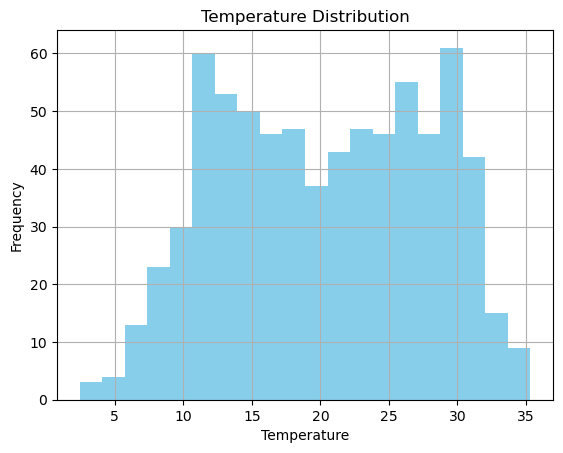

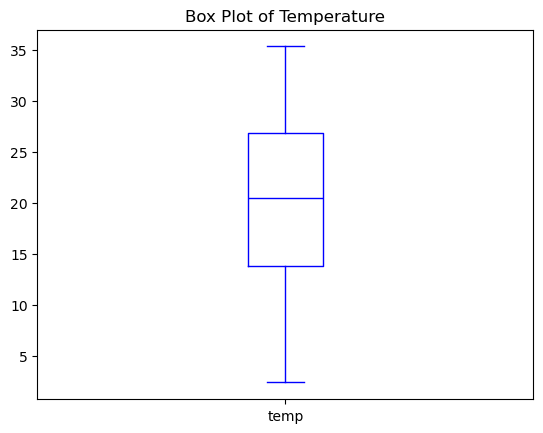

In [77]:
bike_data_cleaned['temp'].hist(bins=20, color='skyblue')
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

bike_data_cleaned['temp'].plot(kind='box', color='blue')
plt.title('Box Plot of Temperature')
plt.show()

## Prepare Data for Model building

In [202]:
# Train test split
X = bike_data_cleaned.drop(columns=['cnt'])
y = bike_data_cleaned['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling. Here we'll try to standardize the numerical columns
columns_to_scale = ['temp', 'windspeed', 'hum']

# Feature scaling using StandardScaler
ss = StandardScaler()
X_train[columns_to_scale] = ss.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = ss.transform(X_test[columns_to_scale])

print(X_train[columns_to_scale].head())

# Feature selection using RFE and VIF
model = LinearRegression()

rfe = RFE(estimator=model,n_features_to_select=5 )
rfe.fit(X_train, y_train)
selected_features_rfe = X_train.columns[rfe.support_]
print("Selected Features by RFE:", selected_features)

X_train_rfe = X_train[selected_features_rfe]
X_test_rfe = X_test[selected_features_rfe]

# print(X_train[columns_to_scale].head())
# print(X_train.describe())
print(X_train_rfe.dtypes)

# Since boolean types are there in the tain set columns we need to convert it as float type
X_train_rfe = X_train_rfe.astype(float)

# print(X_train[columns_to_scale].isnull().sum())
# print(X_test[columns_to_scale].isnull().sum())
# X_train_rfe.fillna(X_train_rfe.mean(), inplace=True)
vif_rfe = calculate_vif(X_train_rfe)
print("VIF After RFE:\n", vif_rfe)


         temp  windspeed       hum
28  -1.669961  -0.541743  0.164104
43  -1.011137   1.122442 -1.210793
42  -1.527337   0.293850 -0.596905
75  -0.470474   0.383342 -0.181283
171  0.989002  -0.172078  1.003680
Selected Features by RFE: Index(['yr', 'holiday', 'temp', 'season_Spring', 'weather_Rain'], dtype='object')
yr                  int64
temp              float64
season_Spring        bool
weather_Cloudy       bool
weather_Rain         bool
dtype: object
VIF After RFE:
           Feature       VIF
0              yr  1.386561
1            temp  1.527738
2   season_Spring  1.747780
3  weather_Cloudy  1.282586
4    weather_Rain  1.005888


## Model building

In [215]:
model.fit(X_train_rfe, y_train)
co_ef = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': model.coef_
})
print(co_ef)

          Feature  Coefficient
0              yr  2084.119478
1            temp   678.195828
2   season_Spring -1638.327843
3  weather_Cloudy  -662.418829
4    weather_Rain -2147.780935


## Predicting and Evaluating the model

In [276]:
# Make predictions on the train set
y_pred_train = model.predict(X_train_rfe)
r2_train = r2_score(y_train, y_pred_train)
print(f"Value of r2 in train set {r2_train}")

# Make predictions on the test set
y_pred = model.predict(X_test_rfe)
print(y_pred[:10])

# Evaluate the mdoel
r2_test = r2_score(y_test, y_pred)
print(f"Value of r2 in test set {r2_test}")

n = len(X_train_rfe)
p = X_train_rfe.shape[1]

# Calculate Adjusted R^2
adjusted_r2 = 1 - ((1 - r2_test) * (n - 1) / (n - p - 1))
print(adjusted_r2)

Value of r2 in train set 0.8145387587021541
[4022.5190301  3482.62167687  513.95123364 2882.25753262 5065.66971862
 5363.5441204  1113.60963873 6367.27860926 3957.35900471 3887.49058944]
Value of r2 in test set 0.781138817223886
0.7789191297717957


## Residual analysis to validate the assumptions on LR

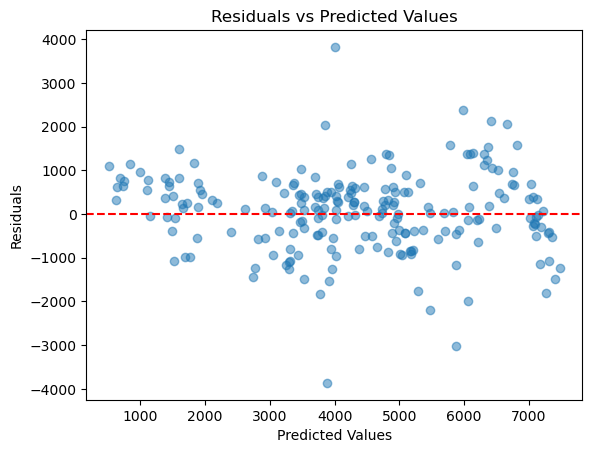

In [279]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# print("Residuals Indices:\n", residuals.index)
# print("X_test Indices:\n", X_test.index)
# print("Outliers:\n", X_test.iloc[outlier_indices])

# residuals.index = X_test.index
# outlier_indices = residuals[(residuals > 3000) | (residuals < -3000)].index
# print(outlier_indices)
# print("Outliers:\n", X_test.iloc[outlier_indices])

## Custom function defined here

In [167]:
# Create a function to draw a bar plot
def drawBarPlot(data, title, xLabel, yLabel, tickValues, tickLabels):
    data.plot(kind='bar')
    plt.title(f'Frequency Distribution of rentals by {title}')
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(ticks=tickValues, labels=tickLabels, rotation=0)
    plt.show()

def drawHistPlot(data, col):
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True, color='blue', bins=20)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    
def drawBoxPlot(data, col):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=bike_data_cleaned[col], color='orange')
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()
    
#  Create a function to remove outliers.
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    
# Calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data